# Rats in the City

##### Libraries

In [1]:
import os
import requests
import glob

import pandas as pd
import geopandas as gpd
import numpy as np
from math import pi

###### Get Data
---
NYC Open Data link

In [2]:
data_url = "https://nycopendata.socrata.com/api/views/3q43-55fe/rows.csv?accessType=DOWNLOAD"
def download_data(url, path="data", name="Rat_Sightings.csv"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)
        
download_data(url=data_url, name="Rat_Sightings.csv")
os.listdir("./data/")

['f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson',
 '.DS_Store',
 'Rat_Sightings.pkl',
 'Rat_Sightings.csv',
 'neighborhoods.htm',
 '.ipynb_checkpoints']

###### ratty data..

* read in data and take some first looks

In [3]:
# read in rat sightings data
df = pd.read_csv("./data/Rat_Sightings.csv")
print(df.shape)
print(df.info())
df.head()

/Users/dominic/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(116194, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116194 entries, 0 to 116193
Data columns (total 38 columns):
Unique Key                        116194 non-null int64
Created Date                      116194 non-null object
Closed Date                       103904 non-null object
Agency                            116194 non-null object
Agency Name                       116194 non-null object
Complaint Type                    116194 non-null object
Descriptor                        116194 non-null object
Location Type                     116188 non-null object
Incident Zip                      115808 non-null float64
Incident Address                  106182 non-null object
Street Name                       106181 non-null object
Cross Street 1                    95153 non-null object
Cross Street 2                    95116 non-null object
Intersection Street 1             9828 non-null object
Intersection Street 2             9828 non-null object
Address Type               

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,15633054,01/01/2010 11:20:45 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11365.0,59-13 159 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.739983,-73.809299,"(40.73998332248969, -73.80929891501533)"
1,15633304,01/02/2010 12:50:36 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10016.0,2 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.743161,-73.976983,"(40.74316088098852, -73.97698314758436)"
2,15633594,01/01/2010 03:05:37 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11377.0,31-14 58 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756987,-73.903618,"(40.756986581184535, -73.90361811283164)"
3,15633599,01/01/2010 08:52:19 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.688903,-73.980929,"(40.68890317557533, -73.98092864957985)"
4,15633605,01/01/2010 04:14:27 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10467.0,2504 BRONX PARK EAST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.863614,-73.870441,"(40.8636140600279, -73.87044117516707)"


##### Initial Data Processing

- We really want to make sure that we don't have any nulls in the zip code level as this is the backbone of our analysis. We will exclude any nulls that exist. 
- Additionally, there are only a few columns that are relevant to this analysis so we will proceed with those. 

In [4]:
# we want our data be viewed at the zip code level so thereforte
# we don't want any indices where the zip code is not provided
df = df[np.isfinite(df["Incident Zip"])]
# also, only a few columns are of importance
df = df[["Created Date", "Location Type", "Incident Zip", "Location"]]
df.head()

,Created Date,Location Type,Incident Zip,Location
0,01/01/2010 11:20:45 AM,1-2 Family Dwelling,11365.0,"(40.73998332248969, -73.80929891501533)"
1,01/02/2010 12:50:36 AM,Commercial Building,10016.0,"(40.74316088098852, -73.97698314758436)"
2,01/01/2010 03:05:37 PM,3+ Family Apt. Building,11377.0,"(40.756986581184535, -73.90361811283164)"
3,01/01/2010 08:52:19 PM,Other (Explain Below),11201.0,"(40.68890317557533, -73.98092864957985)"
4,01/01/2010 04:14:27 PM,3+ Family Apt. Building,10467.0,"(40.8636140600279, -73.87044117516707)"


###### Get rid of the float representation of Zip Code

In [5]:
df["Incident Zip"] = df["Incident Zip"].astype('str', copy=False)
# whenever I convert the column directly into integers, there
# appears to be a lost of values where their original values
# are modified or deleted. So by converting it string it should
# keep the values as is. Then I am going to run a str.split() fun
# to remove the decimals and reassign it back to the column

def remove_dec(row):
    
    return str(row).split(".")[0]

#remove decimals
df["Incident Zip"] = df["Incident Zip"].map(remove_dec)
df["Incident Zip"].head()

0    11365
1    10016
2    11377
3    11201
4    10467
Name: Incident Zip, dtype: object

Rename Column and Convert to `str`.

In [6]:
#rename the col
df.rename(columns = {"Incident Zip":"postalCode"}, inplace=True)
# all the  columns in this dataset are string
for col in df.columns:
    if col != "postalCode":
        df[col] = df[col].astype("str", copy=False)
    else:
        df["postalCode"] = df["postalCode"].astype("int64", copy=False)
        
df = df.sort_values("postalCode")
df.head()

,Created Date,Location Type,postalCode,Location
96076,09/16/2016 12:00:00 AM,Other (Explain Below),83,"(40.7974659648698, -73.95170030179558)"
103569,03/10/2017 12:00:00 AM,Other (Explain Below),83,"(40.793747158241914, -73.95242530605582)"
94923,08/27/2016 12:00:00 AM,Other (Explain Below),83,"(40.775553876942546, -73.97472619286276)"
67498,11/16/2017 12:00:00 AM,Other (Explain Below),83,"(40.78286341773367, -73.96535663892631)"
93065,07/26/2016 12:00:00 AM,Other (Explain Below),83,"(40.78222817871022, -73.97092498645391)"


###### Let's Bring in Neighborhoods

* I'd like to add in another level at which the data can be looked at. Currently, the data has borough and zip code. I'd like to bring in the neighborhood (and i'll just bring in the borough data from the incoming file as well). 

In [7]:
# url 
url = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"

def download_data(url, path="data"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    response = requests.get(url)
    name = os.path.basename(url)
    
    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

# run the function to download the data 
download_data(url)

# read in the web page file
from bs4 import BeautifulSoup as bs

soup = bs(open("./data/neighborhoods.htm"), "html.parser")
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<!-- INCLUDE HEADER Version 1.05 7/26/2007 PAGE LAST MODIFIED Monday, 23-Feb-2015 12:15:40 EST -->
<html lang="en-us" xml:lang="en-us" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>NYC Neighborhood ZIP Code Definitions</title>
<meta content="Definitions of New York City Neighborhoods" name="description"/>
<meta content="neighborhood, Neighborhood, New York City, new york city,new york state, New York State" name="keywords"/>
<!-- THE FOLLOWING STYLE TAG IS FOR IMPORTING STYLE ONLY -->
<style type="text/css">
<!--
-->
</style>
<!-- -->
<!-- -->
<!-- -->
<!-- -->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<link href="/style/twenty16/main.css" media="screen" rel="stylesheet"/>
<link href="/style/twenty16/visualizations.css" m

###### We will need to select the table out of the page. 

In [8]:
table = soup.find_all("table")[0]
table

<table summary=" ">
<tr>
<th abbr="Borough" id="header1">Borough</th>
<th abbr="Neighborhood" id="header2">Neighborhood</th>
<th abbr="ZIP Codes" id="header3">ZIP Codes</th>
</tr><tr>
<td headers="header1" rowspan="7">Bronx</td>
<td headers="header2"> Central Bronx</td>
<td headers="header3"> 10453, 10457, 10460</td>
</tr><tr>
<td headers="header2"> Bronx Park and Fordham</td>
<td headers="header3"> 10458, 10467, 10468</td>
</tr><tr>
<td headers="header2"> High Bridge and Morrisania</td>
<td headers="header3"> 10451, 10452, 10456</td>
</tr><tr>
<td headers="header2"> Hunts Point and Mott Haven</td>
<td headers="header3"> 10454, 10455, 10459, 10474</td>
</tr><tr>
<td headers="header2"> Kingsbridge and Riverdale</td>
<td headers="header3"> 10463, 10471</td>
</tr><tr>
<td headers="header2"> Northeast Bronx</td>
<td headers="header3"> 10466, 10469, 10470, 10475</td>
</tr><tr>
<td headers="header2"> Southeast Bronx</td>
<td headers="header3"> 10461, 10462,10464, 10465, 10472, 10473</td>
</t

Parse through table

In [9]:
nyc_data = []
for i in table.find_all("td"):
    nyc_data.append(i.string)
    
nyc_data

['Bronx',
 ' Central Bronx',
 ' 10453, 10457, 10460',
 ' Bronx Park and Fordham',
 ' 10458, 10467, 10468',
 ' High Bridge and Morrisania',
 ' 10451, 10452, 10456',
 ' Hunts Point and Mott Haven',
 ' 10454, 10455, 10459, 10474',
 ' Kingsbridge and Riverdale',
 ' 10463, 10471',
 ' Northeast Bronx',
 ' 10466, 10469, 10470, 10475',
 ' Southeast Bronx',
 ' 10461, 10462,10464, 10465, 10472, 10473',
 'Brooklyn',
 ' Central Brooklyn',
 ' 11212, 11213, 11216, 11233, 11238',
 ' Southwest Brooklyn',
 ' 11209, 11214, 11228',
 ' Borough Park',
 ' 11204, 11218, 11219, 11230',
 ' Canarsie and Flatlands',
 ' 11234, 11236, 11239',
 ' Southern Brooklyn',
 ' 11223, 11224, 11229, 11235',
 ' Northwest Brooklyn',
 ' 11201, 11205, 11215, 11217, 11231',
 ' Flatbush',
 ' 11203, 11210, 11225, 11226',
 ' East New York and New Lots',
 ' 11207, 11208',
 ' Greenpoint',
 ' 11211, 11222',
 ' Sunset Park',
 ' 11220, 11232',
 ' Bushwick and Williamsburg',
 ' 11206, 11221, 11237',
 'Manhattan',
 ' Central Harlem',
 ' 10

###### Parse this into a dataframe

* I'm going to convert this into a dictionary that will eventually be converted into a dictionary.
    * First, i'm going to gather the Boroughs as the main keys of the eventual dicitionary.
    * I'm going to use the indices of the dictionary to partition the list of the data.
    * Then, once the data is partitioned, I will use the neighborhoods as the sub keys of the eventual dicitionary with the zip codes as the values.
   * Then i'll use the resulting dictionary to generate a dataframe.

In [10]:
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

# indices to partition the data
idxs = []

#iterate through and capture the indices of each broough respectively
for borough in boroughs:
    idxs.append(nyc_data.index(borough))

# make sure that last index is captured to encapsulate all the data
idxs.append(len(nyc_data))
idxs

[0, 15, 38, 59, 80, 89]

Use the indices to partition the total list into a list for each Borough.

In [11]:
# create function to 
def set_partitions (data, indices):
    """ Partition the data based on the input data list and the index 
    list. Return a list of partitioned data. 
    """
    data_partitions = []
    
    i = 1
    while i <= len(indices)-1:
        data_partitions.append(data[indices[i-1]+1:indices[i]])
        i = i + 1
        
    return data_partitions

prt_data = set_partitions(nyc_data, idxs)
prt_data

[[' Central Bronx',
  ' 10453, 10457, 10460',
  ' Bronx Park and Fordham',
  ' 10458, 10467, 10468',
  ' High Bridge and Morrisania',
  ' 10451, 10452, 10456',
  ' Hunts Point and Mott Haven',
  ' 10454, 10455, 10459, 10474',
  ' Kingsbridge and Riverdale',
  ' 10463, 10471',
  ' Northeast Bronx',
  ' 10466, 10469, 10470, 10475',
  ' Southeast Bronx',
  ' 10461, 10462,10464, 10465, 10472, 10473'],
 [' Central Brooklyn',
  ' 11212, 11213, 11216, 11233, 11238',
  ' Southwest Brooklyn',
  ' 11209, 11214, 11228',
  ' Borough Park',
  ' 11204, 11218, 11219, 11230',
  ' Canarsie and Flatlands',
  ' 11234, 11236, 11239',
  ' Southern Brooklyn',
  ' 11223, 11224, 11229, 11235',
  ' Northwest Brooklyn',
  ' 11201, 11205, 11215, 11217, 11231',
  ' Flatbush',
  ' 11203, 11210, 11225, 11226',
  ' East New York and New Lots',
  ' 11207, 11208',
  ' Greenpoint',
  ' 11211, 11222',
  ' Sunset Park',
  ' 11220, 11232',
  ' Bushwick and Williamsburg',
  ' 11206, 11221, 11237'],
 [' Central Harlem',
  '

We're going to create a nested dictionary so that the Zip Codes match to the Neighborhood to the Borough. We'll start by mapping the zip codes to the neighborhoods.

In [12]:
def get_sub_keys(data_partition):
    
    """ Takes in the partitioned data list. Creates a dicitionary 
    relating the zip code values to their corresponding
    neighborhoods.
    """
    
    nyc_dicts = []
    
    for borough in data_partition:
        keys = borough[::2]
        values = borough[1::2]
        new_vals = []
        for val in values:
            new_vals.append(val.split(","))
        nyc_dicts.append(dict(zip(keys, new_vals)))
        
    return nyc_dicts

# return the dictionary
nyc_dict = get_sub_keys(prt_data)
nyc_dict

[{' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 {' Central Brooklyn': [' 11212', ' 11213', ' 11216', ' 11233', ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207', ' 11208'],
  ' Greenpoint': [' 1

Now we can map them to the appropriate Boroughs.

In [13]:
def create_dict(boroughs, sub_dict):
    
    """ Bringing it all back together. Taking the dicitionary of the 
    neighborhoods adn assigning them to the their corresponding borough
    and returning a dictionary. 
    """
    
    d = {}
    
    for boro in boroughs:
        d[boro] = {}
        
    i = 0
    while i < len(boroughs):
        d[boroughs[i]] = sub_dict[i]
        i = i + 1
        
    return d

# now assign to main keys
nyc_dict = create_dict(boroughs, nyc_dict)
nyc_dict

{'Bronx': {' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 'Brooklyn': {' Central Brooklyn': [' 11212',
   ' 11213',
   ' 11216',
   ' 11233',
   ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207',

Now we can move on to the dataframe.

In [14]:
# simply reassigning so that I still have the 
# orig dict to work with if needed
d = nyc_dict

# make dataframe
# gather names
names = []
for header in table.find_all("th"):
    names.append(header.string)

# rename for later merge
names[names.index("ZIP Codes")] = "postalCode"

# compose dataframe
nycdf = pd.DataFrame.from_records([
    [boro, nhood, zipcode] for boro in d for nhood in d[boro] for zipcode in d[boro][nhood] 
])
nycdf.columns = names
# assert types
for col in nycdf.columns:
    if col != "postalCode":
        nycdf[col] = nycdf[col].astype("str", copy=False)
    else:
        nycdf["postalCode"] = nycdf["postalCode"].astype("int64", copy=False)
    
print(nycdf.shape)
nycdf.head(10)

(178, 3)


,Borough,Neighborhood,postalCode
0,Bronx,Central Bronx,10453
1,Bronx,Central Bronx,10457
2,Bronx,Central Bronx,10460
3,Bronx,Bronx Park and Fordham,10458
4,Bronx,Bronx Park and Fordham,10467
5,Bronx,Bronx Park and Fordham,10468
6,Bronx,High Bridge and Morrisania,10451
7,Bronx,High Bridge and Morrisania,10452
8,Bronx,High Bridge and Morrisania,10456
9,Bronx,Hunts Point and Mott Haven,10454


#### Now merge to the main dataset
---
But first observe any differences that may not merge.

In [15]:
# Let's observe the differences 
# find any dissimilar zip codes between the two datasets
list(set(df["postalCode"]).difference(set(nycdf["postalCode"])))

[10112,
 100354,
 10118,
 10120,
 10121,
 10000,
 10271,
 11040,
 11430,
 10151,
 10282,
 10162,
 10174,
 10048,
 11202,
 83,
 10069,
 1123,
 11109,
 11242,
 11249,
 11001,
 10111]

Now merge.

In [16]:
df = df.merge(nycdf, on="postalCode")
df.head(10)

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood
0,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton
1,04/22/2016 12:00:00 AM,Construction Site,10001,"(40.74828132198075, -73.98628555014876)",Manhattan,Chelsea and Clinton
2,10/21/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton
3,03/02/2018 12:00:00 AM,3+ Family Apt. Building,10001,"(40.7504092781165, -73.99696467876097)",Manhattan,Chelsea and Clinton
4,08/13/2011 12:00:00 AM,Vacant Lot,10001,"(40.74480147695398, -73.99141808994322)",Manhattan,Chelsea and Clinton
5,11/25/2016 12:00:00 AM,Commercial Building,10001,"(40.747707573645926, -73.98550250773194)",Manhattan,Chelsea and Clinton
6,10/22/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton
7,12/05/2017 12:00:00 AM,Other (Explain Below),10001,"(40.74541864312235, -73.98710175326369)",Manhattan,Chelsea and Clinton
8,09/07/2016 12:00:00 AM,Commercial Building,10001,"(40.7518557743661, -74.00242542231105)",Manhattan,Chelsea and Clinton
9,06/18/2017 12:00:00 AM,Vacant Lot,10001,"(40.74540267450932, -73.99284353187366)",Manhattan,Chelsea and Clinton


Now we have incorporated the Neighborhood Data. 

---

###### Read in GeoJSON data

   * so i'd like to use this data to create a choropleth map
    
   * i'm going to use a geojson provided in the url below to pull in the zip code boundaries (shape) for that map.
    
   * this is going to be merged into the dataset and won't serve any immediate purpose but will be utilized later when creating the choropleth map.
    
   * basically i'm trying to knock out all (most) the wrangling of this dataset so we can get into some of the interesting visuals that can be put together.
    
   * This data incorporates the boundary coordinates for each of the zip codes so that a choropleth map can eventually be generated.

In [17]:
geo_url = "http://data.beta.nyc//dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
download_data(geo_url)

# read in nyc zip code geojson 
zipdata = r"./data/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
zips = gpd.read_file(zipdata).sort_values("postalCode")
print(zips.info())
zips.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 262 entries, 82 to 189
Data columns (total 12 columns):
OBJECTID      262 non-null int64
postalCode    262 non-null object
PO_NAME       262 non-null object
STATE         262 non-null object
borough       262 non-null object
ST_FIPS       262 non-null object
CTY_FIPS      262 non-null object
BLDGpostal    262 non-null int64
@id           262 non-null object
longitude     262 non-null float64
latitude      262 non-null float64
geometry      262 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 26.6+ KB
None


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...


###### What do the coords look like?

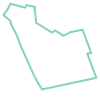

In [18]:
# here goes the exterior/outline of the poly's provided
zips["geometry"][1].exterior

What are we trying to parse?

In [19]:
# this si what we are trying to parse out of the poly's
zips["geometry"][1].exterior.coords.xy

(array('d', [-73.71132911125308, -73.7106837407401, -73.70869392379949, -73.70713084684176, -73.70419967936363, -73.70218528698231, -73.70308721830736, -73.70098278625547, -73.71371033246908, -73.714741836008, -73.71567895968894, -73.71867075939582, -73.71966142935703, -73.72082889049311, -73.72117809110456, -73.72250622247415, -73.72270447144122, -73.72183610276068, -73.72109289651769, -73.71775341502477, -73.71730957335735, -73.71534601002345, -73.71553103019596, -73.71541781535772, -73.71509806179287, -73.71132911125308]),
 array('d', [40.74947450816085, 40.75004039450918, 40.74875836557177, 40.749582740537946, 40.750169552569766, 40.744741887753854, 40.744547257355144, 40.73889569923034, 40.736174704865455, 40.73782936804115, 40.73962914915626, 40.74631499057428, 40.748945236431474, 40.751173028173014, 40.75232189224561, 40.753358470814895, 40.75373371438336, 40.75486513130315, 40.7562813418113, 40.75534755942338, 40.75595782995615, 40.75550893330126, 40.75506458072391, 40.75499844

###### Now we have to get the x and y's of these coordinates to individual columns

In [20]:
def getPolyCoords(row, coord_type, geom="geometry"):
    """ Returns the coordinates ('x' or 'y') of edges of a 
    Polygon exterior.
    """
    
    #parse the exterior of the coordinates 
    exterior = row[geom].exterior
    
    # assign appropriate values
    if coord_type == "x":
        #get the x coords
        return list(exterior.coords.xy[0])
    if coord_type == "y":
        return list(exterior.coords.xy[1])
    
# assign to new cols
zips["poly_x"] = zips.apply(getPolyCoords,
                            coord_type="x",
                            axis=1
                           )
zips["poly_y"] = zips.apply(getPolyCoords,
                            coord_type="y",
                            axis=1
                           )
print(zips.shape)
zips.head()

(262, 14)


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,poly_x,poly_y
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...,"[-73.94922045816277, -73.95577163845807, -73.9...","[40.796909883482776, 40.787905470847036, 40.78..."
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756..."
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...,"[-73.97441674489379, -73.97449300390227, -73.9...","[40.736424418654764, 40.7361171300957, 40.7356..."
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...,"[-73.97986374196766, -73.98863956796875, -73.9...","[40.73497446573838, 40.72293224901508, 40.7241..."
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...,"[-74.04699098912498, -74.04723156029421, -74.0...","[40.69012472491997, 40.69040645829071, 40.6910..."


---
Add in Mercator Coordinates for Bokeh Tile

In [21]:
def conv_poly_ys(row):
    
    import math
    r = 6378137.0
    
    return [math.log(math.tan(math.pi/4+math.radians(x) / 2))*r for x in row]

def conv_poly_xs(row):
    
    import math
    r = 6378137.0
    
    return [math.radians(x)*r for x in row]

zips["xs"] = zips.poly_x.map(conv_poly_xs)
zips["ys"] = zips.poly_y.map(conv_poly_ys)

Now merge back to the main dataset.

In [22]:
#convert for this merge
df['postalCode'] = df["postalCode"].astype('str', copy=False)
# merge data
df = df.merge(
    zips[["postalCode", "poly_x", "poly_y", "xs", "ys"]],
    on="postalCode"
)
print(df.shape)
df.head()

(118267, 10)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys
0,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
1,04/22/2016 12:00:00 AM,Construction Site,10001,"(40.74828132198075, -73.98628555014876)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
2,10/21/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
3,03/02/2018 12:00:00 AM,3+ Family Apt. Building,10001,"(40.7504092781165, -73.99696467876097)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
4,08/13/2011 12:00:00 AM,Vacant Lot,10001,"(40.74480147695398, -73.99141808994322)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."


---
Now we have the coordinates at the zip code level. Later on it will be desired to possibly also have the coordinates at the Neighborhood and the Borough level. 

Below the coordinates are going to be aggregated for each of the respective categories and added as additional columns

In [23]:
# grohp the data by Borough and concatenate all the corresponding coordinates associated with each
boro_data = df.groupby("Borough")[["xs", "ys"]].sum().reset_index().rename(columns={"xs":"Borough_xs", "ys":"Borough_ys"})

# merge in the coordinate for Boroughs
df = df.merge(boro_data)

nhood_data = df.groupby("Neighborhood")[["xs", "ys"]].sum().reset_index().rename(columns={"xs":"Neighborhood_xs", "ys":"Neighborhood_ys"})

# merge in the coordinates for Neighborhoods
df = df.merge(nhood_data)

df.head()

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys
0,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
1,04/22/2016 12:00:00 AM,Construction Site,10001,"(40.74828132198075, -73.98628555014876)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
2,10/21/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
3,03/02/2018 12:00:00 AM,3+ Family Apt. Building,10001,"(40.7504092781165, -73.99696467876097)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
4,08/13/2011 12:00:00 AM,Vacant Lot,10001,"(40.74480147695398, -73.99141808994322)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."


---
Add in Seasons & Parse out Years

In [24]:
# define seasons
winter = ["01", "02", "03"]
spring = ["04", "05", "06"]
summer = ["07", "08", "09"]
fall = ["10", "11", "12"]

def season(row):
    
    month = row.split("/")[0]

    if month in winter:
        return "winter"
    elif month in spring:
        return "spring"
    elif month in summer:
        return "summer"
    elif month in fall:
        return 'fall'
    else:
        return "NA"

seasons = df["Created Date"].map(season)
pd.Series(seasons).head()

0      fall
1    spring
2      fall
3    winter
4    summer
Name: Created Date, dtype: object

Now years

In [25]:
def year(row):
    
    return row.split("/")[2].split(' ')[0]

years = df["Created Date"].map(year)
pd.Series(years).head()

0    2017
1    2016
2    2013
3    2018
4    2011
Name: Created Date, dtype: object

Now months

In [26]:
def get_month(row):
    
    return row.split("/")[0]

months = df["Created Date"].map(get_month)
pd.Series(months).head()

0    12
1    04
2    10
3    03
4    08
Name: Created Date, dtype: object

Conv. months to month names

In [27]:
# create mapping for months
d_months = {"01":"Jan", "02":"Feb", "03":"Mar",
          "04":"Apr", "05":"May", "06":"June",
          "07":"July", "08":"Aug", "09":"Sep",
          "10":"Oct", "11":"Nov", "12":"Dec"}

months = months.map(d_months)
pd.Series(months).head()

0    Dec
1    Apr
2    Oct
3    Mar
4    Aug
Name: Created Date, dtype: object

Now we can add these columns to the dataset.

In [28]:
df["Year"], df["Season"], df["Month"]= years, seasons, months
df.head()

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys,Year,Season,Month
0,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2017,fall,Dec
1,04/22/2016 12:00:00 AM,Construction Site,10001,"(40.74828132198075, -73.98628555014876)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2016,spring,Apr
2,10/21/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2013,fall,Oct
3,03/02/2018 12:00:00 AM,3+ Family Apt. Building,10001,"(40.7504092781165, -73.99696467876097)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2018,winter,Mar
4,08/13/2011 12:00:00 AM,Vacant Lot,10001,"(40.74480147695398, -73.99141808994322)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2011,summer,Aug


###### Agg Values

So I want to store aggregated values in the data so that users can easily access them in visualizations. To accomplish this, i'm going to put together some data manipulations to calculate these values and store them in the dataset. 

1. Month/Year/Season break out of rat sightings per postal code
2. Location Type break out of rat sightings per postal code
3. General Value of rat sightings per postal code
4. General Value of rat sightings per neighborhood
5. Location type break for neighborhood
6. Year/Month/Season for neighborhood
7. General value of rat sightings per borough
8. Location type break out for borough
9. Year/month/season for borough

In [29]:
df_zip_month = (df[["postalCode", "Month"]]
                .assign(n=0)
                .groupby(["postalCode", "Month"])
                .n.count()
                .reset_index()
                .rename(columns = {"n":"Zip_Month_values"})
               )
df_zip_month.head()


,postalCode,Month,Zip_Month_values
0,10001,Apr,31
1,10001,Aug,58
2,10001,Dec,18
3,10001,Feb,12
4,10001,Jan,32


Zip Code - Location Type

In [30]:
df_zip_loctype = (df[["postalCode", "Location Type"]]
                  .assign(n=0)
                  .groupby(["postalCode", "Location Type"])
                  .n.count()
                  .reset_index()
                  .rename(columns = {"n":"Zip_loctype_values"})
               )
# view
df_zip_loctype.head()

,postalCode,Location Type,Zip_loctype_values
0,10001,1-2 Family Dwelling,3
1,10001,1-2 Family Mixed Use Building,2
2,10001,3+ Family Apt. Building,148
3,10001,3+ Family Mixed Use Building,38
4,10001,Catch Basin/Sewer,14


Rat Sightings per Zip Code

In [31]:
df_zip = (df
          .postalCode
          .value_counts()
          .reset_index()
          .rename(columns = {"postalCode":"Zip_values",
                             "index":"postalCode"
                            })
         )
df_zip.head()

,postalCode,Zip_values
0,11221,3474
1,11216,2868
2,10025,2727
3,11238,2619
4,11233,2188


Zip Code - Year

In [32]:
df_zip_year = (df[["postalCode", "Year"]]
               .assign(n=0)
               .groupby(["postalCode", "Year"])
               .n
               .count()
               .reset_index()
               .rename(columns = {"n":"Zip_year_values"})
              )
df_zip_year.head()

,postalCode,Year,Zip_year_values
0,10001,2010,15
1,10001,2011,18
2,10001,2012,28
3,10001,2013,39
4,10001,2014,67


Zip Code - Season

In [33]:
df_zip_season = (df[["postalCode", "Season"]]
                 .assign(n=0)
                 .groupby(['postalCode', "Season"])
                 .n
                 .count()
                 .reset_index()
                 .rename(columns = {"n":"Zip_season_values"})
                )

df_zip_season.head()

,postalCode,Season,Zip_season_values
0,10001,fall,104
1,10001,spring,111
2,10001,summer,169
3,10001,winter,81
4,10002,fall,298


Rat Sightings per Neighborhood

In [34]:
df_nhood = (df
            .Neighborhood
            .value_counts()
            .reset_index()
            .rename(columns = {"Neighborhood":"Neighborhood_values",
                               "index":"Neighborhood"
                              }
                   )
           )
df_nhood.head()

,Neighborhood,Neighborhood_values
0,Central Brooklyn,10494
1,Bushwick and Williamsburg,6705
2,Northwest Brooklyn,6306
3,Inwood and Washington Heights,5417
4,Bronx Park and Fordham,5249


Neighborhood - Location Type

In [35]:
df_nhood_loctype = (df[["Neighborhood", "Location Type"]]
                    .assign(Neighborhood_loctype_values=0)
                    .groupby(["Neighborhood", "Location Type"])
                    .Neighborhood_loctype_values
                    .count()
                    .reset_index()
                   )

df_nhood_loctype.head()

,Neighborhood,Location Type,Neighborhood_loctype_values
0,Borough Park,1-2 Family Dwelling,401
1,Borough Park,1-2 Family Mixed Use Building,40
2,Borough Park,3+ Family Apt. Building,547
3,Borough Park,3+ Family Mixed Use Building,120
4,Borough Park,Catch Basin/Sewer,12


Neighborhood - Year

In [36]:
df_nhood_year = (df[["Neighborhood", "Year"]]
                    .assign(Neighborhood_year_values=0)
                    .groupby(["Neighborhood", "Year"])
                    .Neighborhood_year_values
                    .count()
                    .reset_index()
                   )
df_nhood_year.head()

,Neighborhood,Year,Neighborhood_year_values
0,Borough Park,2010,190
1,Borough Park,2011,201
2,Borough Park,2012,149
3,Borough Park,2013,139
4,Borough Park,2014,146


Neighborhood - Month

In [37]:
df_nhood_month = (df[["Neighborhood", "Month"]]
                    .assign(Neighborhood_monrh_values=0)
                    .groupby(["Neighborhood", "Month"])
                    .Neighborhood_monrh_values
                    .count()
                    .reset_index()
                   )
df_nhood_month.head()

,Neighborhood,Month,Neighborhood_monrh_values
0,Borough Park,Apr,170
1,Borough Park,Aug,201
2,Borough Park,Dec,89
3,Borough Park,Feb,83
4,Borough Park,Jan,80


Neighborhood - Season

In [38]:
df_nhood_season = (df[["Neighborhood", "Season"]]
                    .assign(Neighborhood_season_values=0)
                    .groupby(["Neighborhood", "Season"])
                    .Neighborhood_season_values
                    .count()
                    .reset_index()
                   )
df_nhood_season.head()

,Neighborhood,Season,Neighborhood_season_values
0,Borough Park,fall,294
1,Borough Park,spring,595
2,Borough Park,summer,580
3,Borough Park,winter,283
4,Bronx Park and Fordham,fall,1090


Rat Sightings per Borough

In [39]:
df_boro = (df
           .Borough
           .value_counts()
           .reset_index()
           .rename(columns = {"Borough":"Borough_values",
                              "index":"Borough"}
                  )
          )
df_boro.head()

,Borough,Borough_values
0,Brooklyn,40212
1,Manhattan,31023
2,Bronx,24350
3,Queens,17192
4,Staten Island,5490


Borough - Location Type

In [40]:
df_boro_loctype = (df[["Borough", "Location Type"]]
                    .assign(Borough_loctype_values=0)
                    .groupby(["Borough", "Location Type"])
                    .Borough_loctype_values
                    .count()
                    .reset_index()
                   )

df_boro_loctype.head()

,Borough,Location Type,Borough_loctype_values
0,Bronx,1-2 Family Dwelling,3875
1,Bronx,1-2 Family Mixed Use Building,319
2,Bronx,3+ Family Apt. Building,13332
3,Bronx,3+ Family Mixed Use Building,2108
4,Bronx,Catch Basin/Sewer,148


Borough - Year

In [41]:
df_boro_year = (df[["Borough", "Year"]]
                    .assign(Borough_year_values=0)
                    .groupby(["Borough", "Year"])
                    .Borough_year_values
                    .count()
                    .reset_index()
                   )
df_boro_year.head()

,Borough,Year,Borough_year_values
0,Bronx,2010,2101
1,Bronx,2011,2226
2,Bronx,2012,2179
3,Bronx,2013,2235
4,Bronx,2014,2864


Borough - Month

In [42]:
df_boro_month = (df[["Borough", "Month"]]
                    .assign(Borough_month_values=0)
                    .groupby(["Borough", "Month"])
                    .Borough_month_values
                    .count()
                    .reset_index()
                   )
df_boro_month.head()

,Borough,Month,Borough_month_values
0,Bronx,Apr,2099
1,Bronx,Aug,2230
2,Bronx,Dec,1488
3,Bronx,Feb,1718
4,Bronx,Jan,1601


Borough - Season

In [43]:
df_boro_season = (df[["Borough", "Season"]]
                    .assign(Borough_season_values=0)
                    .groupby(["Borough", "Season"])
                    .Borough_season_values
                    .count()
                    .reset_index()
                   )
df_boro_season.head()

,Borough,Season,Borough_season_values
0,Bronx,fall,5040
1,Bronx,spring,7015
2,Bronx,summer,7003
3,Bronx,winter,5292
4,Brooklyn,fall,7369


###### Combine Data

---

First, we're going to reduce the main dataset. 

In [44]:
# here's a refresher of what we're working with
df.head()

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys,Year,Season,Month
0,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2017,fall,Dec
1,04/22/2016 12:00:00 AM,Construction Site,10001,"(40.74828132198075, -73.98628555014876)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2016,spring,Apr
2,10/21/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.75043125539278, -74.00218355523813)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2013,fall,Oct
3,03/02/2018 12:00:00 AM,3+ Family Apt. Building,10001,"(40.7504092781165, -73.99696467876097)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2018,winter,Mar
4,08/13/2011 12:00:00 AM,Vacant Lot,10001,"(40.74480147695398, -73.99141808994322)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2011,summer,Aug


We only need `postalCode`, `Borough`, `Neighborhood`, and the GIS columns now. The rest of the information will be incorporated through the merges of the datasets we have been working on. 

In [45]:
df = (df[["postalCode", "Borough", "Neighborhood",
          "poly_x", "poly_y", "xs", "ys", "Borough_xs",
          "Borough_ys", "Neighborhood_xs",
          "Neighborhood_ys"]]
      
      # only need information from each unique zip
      .drop_duplicates(subset=["postalCode"])
      # reindex data
      .reset_index(drop=True)
     )
df.head()

,postalCode,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys
0,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
1,10011,Manhattan,Chelsea and Clinton,"[-73.99231888616657, -73.99416491652708, -73.9...","[40.74356834094625, 40.74103096024326, 40.7396...","[-8236787.2610215815, -8236992.760181303, -823...","[4974591.31423676, 4974218.504999, 4974019.049...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
2,10018,Manhattan,Chelsea and Clinton,"[-74.00170164222186, -73.99395968106315, -73.9...","[40.76138075542977, 40.758252769648045, 40.757...","[-8237831.744647894, -8236969.913473965, -8236...","[4977208.835856652, 4976749.12981087, 4976653....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
3,10019,Manhattan,Chelsea and Clinton,"[-73.9938383514649, -73.98477434066237, -73.98...","[40.7730462090637, 40.769219333323136, 40.7698...","[-8236956.40712487, -8235947.406057787, -82358...","[4978923.446089934, 4978360.931548445, 4978452...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
4,10020,Manhattan,Chelsea and Clinton,"[-73.9772002585963, -73.9776548242447, -73.978...","[40.75853795896474, 40.7579114460897, 40.75728...","[-8235104.263098965, -8235154.865115477, -8235...","[4976791.041909856, 4976698.968326858, 4976606...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."


We're going to combine the data iteratively but first going to display what can be expected from the merges. 

In [46]:
(df
 .merge(df_zip_year)
 .drop_duplicates(subset=["postalCode","Borough", "Neighborhood", "Year"])
 .head()
)

,postalCode,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys,Year,Zip_year_values
0,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2010,15
1,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2011,18
2,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2012,28
3,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2013,39
4,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...",2014,67


Now define function to iteratively add the datasets

In [48]:
datasets = [df_boro, df_boro_loctype, df_boro_month, df_boro_season, df_boro_year,
            df_nhood, df_nhood_loctype, df_nhood_month, df_nhood_season, df_nhood_year,
            df_zip, df_zip_loctype, df_zip_month, df_zip_season, df_zip_year
           ]
def combine_data(main_df = df, datasets=datasets):
    
    main_df = main_df.copy()
    
    for dataset in datasets:
        
        # get the cols of the dataset
        cols = [*dataset.columns]
        
        if "Year" in cols:
            
            main_df = (main_df
                       .merge(dataset)
                       .drop_duplicates(subset=["postalCode", "Borough",
                                                "Neighborhood", "Year"
                                               ]
                                       )
                      )
        elif "Month" in cols:
            
            main_df = (main_df
                       .merge(dataset)
                       .drop_duplicates(subset=["postalCode", "Borough",
                                                "Neighborhood", "Month"
                                               ]
                                       )
                      )

        elif "Season" in cols:
            
            main_df = (main_df
                       .merge(dataset)
                       .drop_duplicates(subset=["postalCode", "Borough",
                                                "Neighborhood", "Season"
                                               ]
                                       )
                      )
        elif "Location Type" in cols:
            
            main_df = (main_df
                       .merge(dataset)
                       .drop_duplicates(subset=["postalCode", "Borough",
                                                "Neighborhood", "Location Type"
                                               ]
                                       )
                      )
        else: 
            main_df = (main_df
                       .merge(dataset)
                      )
            
    return main_df

Run Fun

In [49]:
new_df = combine_data()
new_df.head()

,postalCode,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,...,Neighborhood_values,Neighborhood_loctype_values,Neighborhood_monrh_values,Neighborhood_season_values,Neighborhood_year_values,Zip_values,Zip_loctype_values,Zip_Month_values,Zip_season_values,Zip_year_values
0,10001,Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...",...,2348,48,182,524,207,465,3,31,104,15
1,10011,Manhattan,Chelsea and Clinton,"[-73.99231888616657, -73.99416491652708, -73.9...","[40.74356834094625, 40.74103096024326, 40.7396...","[-8236787.2610215815, -8236992.760181303, -823...","[4974591.31423676, 4974218.504999, 4974019.049...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...",...,2348,48,182,524,207,679,31,45,164,51
2,10019,Manhattan,Chelsea and Clinton,"[-73.9938383514649, -73.98477434066237, -73.98...","[40.7730462090637, 40.769219333323136, 40.7698...","[-8236956.40712487, -8235947.406057787, -82358...","[4978923.446089934, 4978360.931548445, 4978452...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...",...,2348,48,182,524,207,482,3,49,102,66
3,10036,Manhattan,Chelsea and Clinton,"[-73.98134106844775, -73.9781160605814, -73.98...","[40.758645323851304, 40.7572844526636, 40.7534...","[-8235565.215943101, -8235206.2097096145, -823...","[4976806.8205550425, 4976606.824989868, 497604...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8238562.950607049, -8238491.138551269, -8238...",...,2348,48,182,524,207,570,11,46,118,64
4,10002,Manhattan,Lower East Side,"[-73.97441674489379, -73.97449300390227, -73.9...","[40.736424418654764, 40.7361171300957, 40.7356...","[-8234794.403770987, -8234802.892884979, -8234...","[4973541.716908929, 4973496.572074751, 4973425...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-8234794.403770987, -8234802.892884979, -8234...",...,3509,55,291,751,319,1491,18,139,298,89


In [50]:
print(new_df.shape)

(167, 30)


Do Some Checks

In [59]:
new_df[["postalCode", "Year", "Zip_year_values"]].sort_values(["Year","postalCode"]).head(15)

,postalCode,Year,Zip_year_values
0,10001,2010,15
4,10002,2010,89
5,10003,2010,97
7,10004,2010,20
8,10007,2010,20
6,10009,2010,133
10,10010,2010,19
1,10011,2010,51
14,10012,2010,42
15,10013,2010,55


In [58]:
df_zip_year.sort_values(["Year","postalCode"]).head(15)

,postalCode,Year,Zip_year_values
0,10001,2010,15
9,10002,2010,89
18,10003,2010,97
27,10004,2010,20
43,10006,2010,1
52,10007,2010,20
61,10009,2010,133
70,10010,2010,19
79,10011,2010,51
88,10012,2010,42


Now we have our wrangled dataset and can move on to visualization.

In [ ]:
df.to_pickle("./data/Rat_Sightings.pkl")
df.head()